In [17]:
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import glob
from sklearn.preprocessing import PolynomialFeatures, StandardScaler, MinMaxScaler, LabelEncoder, KBinsDiscretizer, OneHotEncoder
from sklearn.linear_model import Lasso
from sklearn.feature_selection import RFE
from sklearn.ensemble import RandomForestRegressor
from sklearn.decomposition import PCA
from statsmodels.stats.outliers_influence import variance_inflation_factor


### Data Collection

In [18]:
dnames = ["train_FD001","test_FD001","RUL_FD001"]
rnames = ["train","test","RUL"]
for i,dname in enumerate(dnames):
    read_files = glob.glob(f"/Users/aswathshakthi/PycharmProjects/MLOps/Predictive_maintenance/data/raw/{dname}.txt")
    with open(f"/Users/aswathshakthi/PycharmProjects/MLOps/Predictive_maintenance/data/interim/{rnames[i]}.txt", "wb") as outfile:
        for f in read_files:
            with open(f, "rb") as infile:
                outfile.write(infile.read())
            


In [19]:
# Give names to the features
index_names = ['engine', 'cycle']
setting_names = ['setting_1', 'setting_2', 'setting_3']
sensor_names=[ "s1","s2","s3","s4","s5","s6","s7","s8","s9","s10","s11","s12","s13","s14","s15","s16","s17","s18","s19","s20","s21" ]
col_names = index_names + setting_names + sensor_names

df_train = pd.read_csv(('/Users/aswathshakthi/PycharmProjects/MLOps/Predictive_maintenance/data/interim/train.txt'), sep='\s+', header=None, names=col_names)
df_test = pd.read_csv(('/Users/aswathshakthi/PycharmProjects/MLOps/Predictive_maintenance/data/interim/test.txt'), sep='\s+', header=None, names=col_names)
df_test_RUL = pd.read_csv(('/Users/aswathshakthi/PycharmProjects/MLOps/Predictive_maintenance/data/interim/RUL.txt'), sep='\s+', header=None, names=['RUL'])

In [20]:
df_train

,engine,cycle,setting_1,setting_2,setting_3,s1,s2,s3,s4,s5,...,s12,s13,s14,s15,s16,s17,s18,s19,s20,s21
0,1,1,-0.0007,-0.0004,100.0,518.67,641.82,1589.70,1400.60,14.62,...,521.66,2388.02,8138.62,8.4195,0.03,392,2388,100.0,39.06,23.4190
1,1,2,0.0019,-0.0003,100.0,518.67,642.15,1591.82,1403.14,14.62,...,522.28,2388.07,8131.49,8.4318,0.03,392,2388,100.0,39.00,23.4236
2,1,3,-0.0043,0.0003,100.0,518.67,642.35,1587.99,1404.20,14.62,...,522.42,2388.03,8133.23,8.4178,0.03,390,2388,100.0,38.95,23.3442
3,1,4,0.0007,0.0000,100.0,518.67,642.35,1582.79,1401.87,14.62,...,522.86,2388.08,8133.83,8.3682,0.03,392,2388,100.0,38.88,23.3739
4,1,5,-0.0019,-0.0002,100.0,518.67,642.37,1582.85,1406.22,14.62,...,522.19,2388.04,8133.80,8.4294,0.03,393,2388,100.0,38.90,23.4044
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20626,100,196,-0.0004,-0.0003,100.0,518.67,643.49,1597.98,1428.63,14.62,...,519.49,2388.26,8137.60,8.4956,0.03,397,2388,100.0,38.49,22.9735
20627,100,197,-0.0016,-0.0005,100.0,518.67,643.54,1604.50,1433.58,14.62,...,519.68,2388.22,8136.50,8.5139,0.03,395,2388,100.0,38.30,23.1594
20628,100,198,0.0004,0.0000,100.0,518.67,643.42,1602.46,1428.18,14.62,...,520.01,2388.24,8141.05,8.5646,0.03,398,2388,100.0,38.44,22.9333
20629,100,199,-0.0011,0.0003,100.0,518.67,643.23,1605.26,1426.53,14.62,...,519.67,2388.23,8139.29,8.5389,0.03,395,2388,100.0,38.29,23.0640


In [21]:
df_test_RUL

,RUL
0,112
1,98
2,69
3,82
4,91
...,...
95,137
96,82
97,59
98,117


### Cleaning

In [22]:
df_train_RUL = df_train.groupby(['engine']).agg({'cycle':'max'})
df_train_RUL.rename(columns={'cycle':'life'},inplace=True)
df_train_RUL.head()

,life
engine,
1,192
2,287
3,179
4,189
5,269


In [23]:
df_train = df_train.merge(df_train_RUL,on='engine',how='left')

In [24]:
df_train['RUL']=df_train['life']-df_train['cycle']
df_train.drop(['life'],axis=1,inplace=True)
df_train.to_csv("/Users/aswathshakthi/PycharmProjects/MLOps/Predictive_maintenance/data/processed/df_train.csv",index=False)
df_train

,engine,cycle,setting_1,setting_2,setting_3,s1,s2,s3,s4,s5,...,s13,s14,s15,s16,s17,s18,s19,s20,s21,RUL
0,1,1,-0.0007,-0.0004,100.0,518.67,641.82,1589.70,1400.60,14.62,...,2388.02,8138.62,8.4195,0.03,392,2388,100.0,39.06,23.4190,191
1,1,2,0.0019,-0.0003,100.0,518.67,642.15,1591.82,1403.14,14.62,...,2388.07,8131.49,8.4318,0.03,392,2388,100.0,39.00,23.4236,190
2,1,3,-0.0043,0.0003,100.0,518.67,642.35,1587.99,1404.20,14.62,...,2388.03,8133.23,8.4178,0.03,390,2388,100.0,38.95,23.3442,189
3,1,4,0.0007,0.0000,100.0,518.67,642.35,1582.79,1401.87,14.62,...,2388.08,8133.83,8.3682,0.03,392,2388,100.0,38.88,23.3739,188
4,1,5,-0.0019,-0.0002,100.0,518.67,642.37,1582.85,1406.22,14.62,...,2388.04,8133.80,8.4294,0.03,393,2388,100.0,38.90,23.4044,187
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20626,100,196,-0.0004,-0.0003,100.0,518.67,643.49,1597.98,1428.63,14.62,...,2388.26,8137.60,8.4956,0.03,397,2388,100.0,38.49,22.9735,4
20627,100,197,-0.0016,-0.0005,100.0,518.67,643.54,1604.50,1433.58,14.62,...,2388.22,8136.50,8.5139,0.03,395,2388,100.0,38.30,23.1594,3
20628,100,198,0.0004,0.0000,100.0,518.67,643.42,1602.46,1428.18,14.62,...,2388.24,8141.05,8.5646,0.03,398,2388,100.0,38.44,22.9333,2
20629,100,199,-0.0011,0.0003,100.0,518.67,643.23,1605.26,1426.53,14.62,...,2388.23,8139.29,8.5389,0.03,395,2388,100.0,38.29,23.0640,1


In [25]:
df_test_RUL.columns = ['RUL']
df_test_RUL['engine'] = range(1, len(df_test_RUL) + 1)
df_test = df_test.merge(df_test_RUL,on='engine',how='left')
df_test.to_csv("/Users/aswathshakthi/PycharmProjects/MLOps/Predictive_maintenance/data/processed/df_test.csv",index=False)
df_test

,engine,cycle,setting_1,setting_2,setting_3,s1,s2,s3,s4,s5,...,s13,s14,s15,s16,s17,s18,s19,s20,s21,RUL
0,1,1,0.0023,0.0003,100.0,518.67,643.02,1585.29,1398.21,14.62,...,2388.03,8125.55,8.4052,0.03,392,2388,100.0,38.86,23.3735,112
1,1,2,-0.0027,-0.0003,100.0,518.67,641.71,1588.45,1395.42,14.62,...,2388.06,8139.62,8.3803,0.03,393,2388,100.0,39.02,23.3916,112
2,1,3,0.0003,0.0001,100.0,518.67,642.46,1586.94,1401.34,14.62,...,2388.03,8130.10,8.4441,0.03,393,2388,100.0,39.08,23.4166,112
3,1,4,0.0042,0.0000,100.0,518.67,642.44,1584.12,1406.42,14.62,...,2388.05,8132.90,8.3917,0.03,391,2388,100.0,39.00,23.3737,112
4,1,5,0.0014,0.0000,100.0,518.67,642.51,1587.19,1401.92,14.62,...,2388.03,8129.54,8.4031,0.03,390,2388,100.0,38.99,23.4130,112
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13091,100,194,0.0049,0.0000,100.0,518.67,643.24,1599.45,1415.79,14.62,...,2388.00,8213.28,8.4715,0.03,394,2388,100.0,38.65,23.1974,20
13092,100,195,-0.0011,-0.0001,100.0,518.67,643.22,1595.69,1422.05,14.62,...,2388.09,8210.85,8.4512,0.03,395,2388,100.0,38.57,23.2771,20
13093,100,196,-0.0006,-0.0003,100.0,518.67,643.44,1593.15,1406.82,14.62,...,2388.04,8217.24,8.4569,0.03,395,2388,100.0,38.62,23.2051,20
13094,100,197,-0.0038,0.0001,100.0,518.67,643.26,1594.99,1419.36,14.62,...,2388.08,8220.48,8.4711,0.03,395,2388,100.0,38.66,23.2699,20


### Correlation

In [29]:
def plot_correlation_matrices(df):
    corr_methods = ['pearson']
    
    for method in corr_methods:
        corr_matrix = df.corr(method=method)
        plt.figure(figsize=(10, 8))
        sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm', cbar=True)
        plt.title(f'{method.capitalize()} Correlation Matrix')
        plt.show()

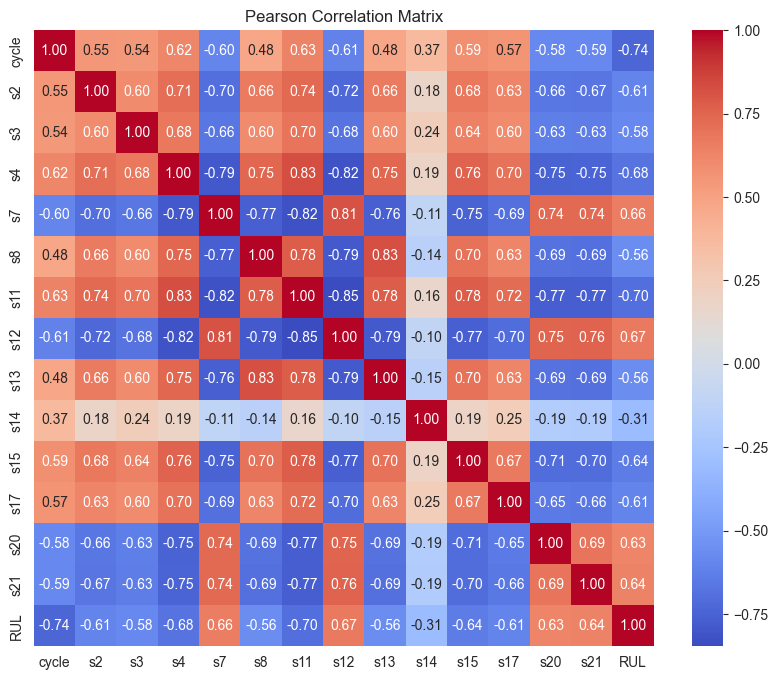

In [33]:
# Example usage
plot_correlation_matrices(df_train)

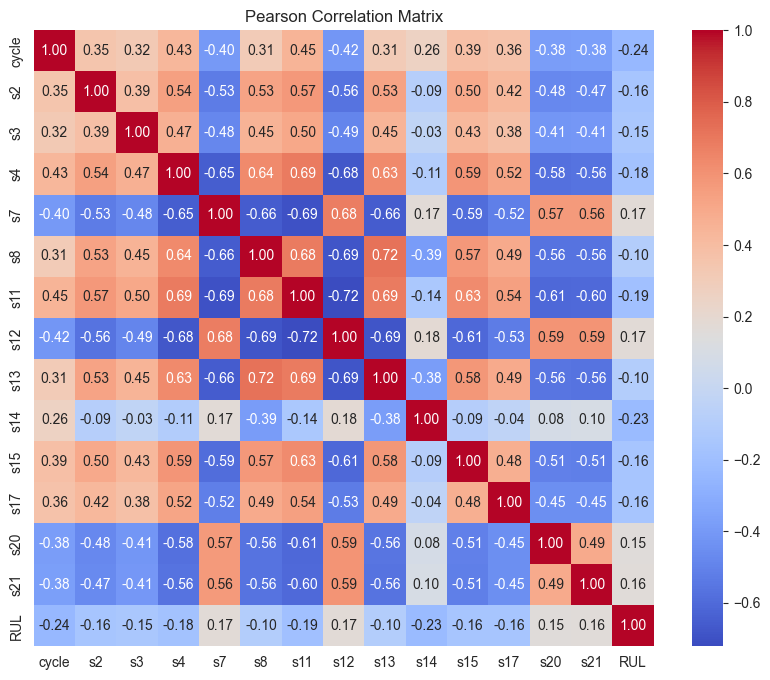

In [34]:
# Example usage
plot_correlation_matrices(df_test)

In [32]:
df_train.drop(columns=["engine","setting_1","setting_2","setting_3","s1","s5","s6","s9","s10","s16","s18","s19"], inplace=True)
df_test.drop(columns=["engine","setting_1","setting_2","setting_3","s1","s5","s6","s9","s10","s16","s18","s19"], inplace=True)

In [35]:
df_train.to_csv("/Users/aswathshakthi/PycharmProjects/MLOps/Predictive_maintenance/data/processed/df_train_processed.csv",index=False)
df_test.to_csv("/Users/aswathshakthi/PycharmProjects/MLOps/Predictive_maintenance/data/processed/df_test_processed.csv",index=False)

In [36]:
df_train

,cycle,s2,s3,s4,s7,s8,s11,s12,s13,s14,s15,s17,s20,s21,RUL
0,1,641.82,1589.70,1400.60,554.36,2388.06,47.47,521.66,2388.02,8138.62,8.4195,392,39.06,23.4190,191
1,2,642.15,1591.82,1403.14,553.75,2388.04,47.49,522.28,2388.07,8131.49,8.4318,392,39.00,23.4236,190
2,3,642.35,1587.99,1404.20,554.26,2388.08,47.27,522.42,2388.03,8133.23,8.4178,390,38.95,23.3442,189
3,4,642.35,1582.79,1401.87,554.45,2388.11,47.13,522.86,2388.08,8133.83,8.3682,392,38.88,23.3739,188
4,5,642.37,1582.85,1406.22,554.00,2388.06,47.28,522.19,2388.04,8133.80,8.4294,393,38.90,23.4044,187
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20626,196,643.49,1597.98,1428.63,551.43,2388.19,48.07,519.49,2388.26,8137.60,8.4956,397,38.49,22.9735,4
20627,197,643.54,1604.50,1433.58,550.86,2388.23,48.04,519.68,2388.22,8136.50,8.5139,395,38.30,23.1594,3
20628,198,643.42,1602.46,1428.18,550.94,2388.24,48.09,520.01,2388.24,8141.05,8.5646,398,38.44,22.9333,2
20629,199,643.23,1605.26,1426.53,550.68,2388.25,48.39,519.67,2388.23,8139.29,8.5389,395,38.29,23.0640,1
